# Проект: Аналитика данных по онлайн обучению сотрудников

Скорость и своевременное прохождение мобильного обучения - важная задача для онбординга.
В ритейл компании от того, насколько быстро и качественно сотрудник изучит базовый материал, зависит успех продаж магазина. 

Также есть (пока не подтвержденная на реальных цифрах) теория о взаимосвязи скорости и последовательности обучения с текучестью новых сотрудников. 
Эту теорию таким датасетом пока проверить не получится, но это может быть задача на будущее.

Данные самые реальные из рабочей практики. 
Ставится задача их проанализировать,найти взаимосвязи и понять, есть ли какой-то фактор в имеющемся датасете, влияющий на прохождение обучения (оценку, длительность, факт)



In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from scipy import stats
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [107]:
df_hr = pd.read_csv('Training_Status.csv')

In [108]:
df_hr

,User Name,Primary Job Profile,Store,User Start Date,Lesson Code,Lesson Title,Lesson Score % (Best),Lesson Status (Latest),Lesson Status (Best),Lesson Uses,Actual Duration (HH:MM:SS),Lesson Certified Date
0,168704,Sales Assistant,R007-Filion,2020-02-05,0016_RU,Внутренняя Организация,0.00,Зачтено,Зачтено,2,1:02:06 AM,2020-02-13
1,168704,Sales Assistant,R007-Filion,2020-02-05,1001,Добро пожаловать в JYSK,0.95,Зачтено,Зачтено,5,2:24:48 AM,2020-02-11
2,168704,Sales Assistant,R007-Filion,2020-02-05,1002,Продажи и Обслуживание JYSK,1.00,Зачтено,Зачтено,6,4:46:11 AM,2020-02-11
3,168704,Sales Assistant,R007-Filion,2020-02-05,1003,Seamless Cross Channel - Омниканальная розничн...,0.00,Зачтено,Зачтено,2,12:16:21 AM,2020-02-13
4,168704,Sales Assistant,R007-Filion,2020-02-05,2002,Одеяла,1.00,Зачтено,Зачтено,4,1:26:16 AM,2020-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...
1789,196817,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-10-25,2006,Матрасы,0.88,Зачтено,Зачтено,1,12:57:35 AM,2021-11-22
1790,196817,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-10-25,4024,Новые Правила Возврата,1.00,Зачтено,Зачтено,2,12:13:07 AM,2021-11-24
1791,196817,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-10-25,5001,"Эргономика, вспомогательное оборудование и инс...",1.00,Зачтено,Зачтено,3,12:32:25 AM,2021-11-24
1792,196817,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-10-25,5002,Воровство и ограбление в магазине,0.88,Зачтено,Зачтено,3,12:40:28 AM,2021-11-24


In [109]:
# Проверим датасет на наличие пустых значений и тип данных

df_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User Name                   1794 non-null   object 
 1   Primary Job Profile         1794 non-null   object 
 2   Store                       1768 non-null   object 
 3   User Start Date             1794 non-null   object 
 4   Lesson Code                 1794 non-null   object 
 5   Lesson Title                1794 non-null   object 
 6   Lesson Score % (Best)       1794 non-null   float64
 7   Lesson Status (Latest)      1794 non-null   object 
 8   Lesson Status (Best)        1794 non-null   object 
 9   Lesson Uses                 1794 non-null   int64  
 10  Actual Duration (HH:MM:SS)  1794 non-null   object 
 11  Lesson Certified Date       1676 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 168.3+ KB


* Мы видим, что в графе **Дата сертификации по курсу** много отсутствующих значений. Это говорит о том, что 118 курсов еще не завершены
* В графе **Магазин** также есть отсутствующие значения. Это потому, что среди проходящих обучение есть люди, не принадлежащие ни к одному из магазинов (Территориальные менеджеры)
* Также только в одной колонке данные считаются как целое значение и еще в одной - как число с плавающей точкой, остальные расцениваются как текст. А это уже проблема, так как усложняет нам возможность работать с данными. Мы должны поменять тип данных
*  Сейчас есть два столбца с датой и один с временем, которые сейчас рассматриваются как текст, нужно их преобразовать. Попробуем

In [110]:
# creat1ing initial dataframe
temp_df = pd.DataFrame(df_hr[['User Name', 
                              'Primary Job Profile', 
                              'Store', 
                              'Lesson Title',
                              'Lesson Status (Latest)', 
                              'Lesson Status (Best)']])

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df_hr['User Name_ID'] = labelencoder.fit_transform(temp_df['User Name'])
df_hr['Primary Job Profile_ID'] = labelencoder.fit_transform(temp_df['Primary Job Profile'])
print (labelencoder.classes_)
df_hr['Store_ID'] = labelencoder.fit_transform(temp_df['Store'])
print (labelencoder.classes_)
df_hr['Lesson Title_ID'] = labelencoder.fit_transform(temp_df['Lesson Title'])
print (labelencoder.classes_)
df_hr['LatestStatus_ID'] = labelencoder.fit_transform(temp_df['Lesson Status (Latest)'])
print (labelencoder.classes_)
df_hr['BestStatus_ID'] = labelencoder.fit_transform(temp_df['Lesson Status (Best)'])
print (labelencoder.classes_)

['Area Responsible' 'Deputy Store Manager' 'District Manager'
 'Logistics Responsible' 'Sales Assistant' 'Store Manager']
['R001-Moscow Troyka' 'R002-Moscow Altufievo' 'R003-Moscow Kalita'
 'R004-Moscow Mari' 'R005-Moscow Zelenopark' 'R006-Moscow Otrada'
 'R007-Filion' 'R008-Tula/Maksi' 'R009-Moscow Kapitoliy'
 'R010-Moscow Sofia' 'R011-Krasny Kit/ Mytishi' 'R012-Nebo / Moscow'
 'R013-Gagarinskiy / Moscow' 'R014-Butovo / Moscow' nan]
['Seamless Cross Channel - Омниканальная розничная среда'
 'Внутренняя Организация' 'Воровство и ограбление в магазине'
 'Всё для окон' 'Добро пожаловать в JYSK'
 'Индивидуальный план развития (PDP)' 'Матрасы' 'Мебель'
 'Новые Правила Возврата' 'Одеяла' 'Продажи и Обслуживание JYSK'
 'Садовая Мебель' 'Эргономика, вспомогательное оборудование и инструменты']
['Завершено' 'Зачтено' 'Не завершено' 'Не начато']
['Завершено' 'Зачтено' 'Не завершено' 'Не начато']


In [111]:
# Создадим столбец FinishedLesson, чтобы распределить уроки на "сделано" и "не сделано"
df_hr['FinishedLesson'] = df_hr['BestStatus_ID'].apply(lambda c: 1 if (c == 1 or c == 0) else 0)
df_hr[['FinishedLesson','BestStatus_ID']]

,FinishedLesson,BestStatus_ID
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1789,1,1
1790,1,1
1791,1,1
1792,1,1


In [112]:
# Перепроверим себя, посмотрим, сколько не выполненных уроков
df_hr_whoDIDNTfinishlessons = df_hr[df_hr['FinishedLesson'] == 0]
df_hr_whoDIDNTfinishlessons

,User Name,Primary Job Profile,Store,User Start Date,Lesson Code,Lesson Title,Lesson Score % (Best),Lesson Status (Latest),Lesson Status (Best),Lesson Uses,Actual Duration (HH:MM:SS),Lesson Certified Date,User Name_ID,Primary Job Profile_ID,Store_ID,Lesson Title_ID,LatestStatus_ID,BestStatus_ID,FinishedLesson
182,200535,Sales Assistant,R009-Moscow Kapitoliy,2021-12-02,0016_RU,Внутренняя Организация,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,128,4,8,1,3,3,0
183,200535,Sales Assistant,R009-Moscow Kapitoliy,2021-12-02,1001,Добро пожаловать в JYSK,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,128,4,8,4,3,3,0
184,200535,Sales Assistant,R009-Moscow Kapitoliy,2021-12-02,1002,Продажи и Обслуживание JYSK,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,128,4,8,10,3,3,0
185,200535,Sales Assistant,R009-Moscow Kapitoliy,2021-12-02,1003,Seamless Cross Channel - Омниканальная розничн...,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,128,4,8,0,3,3,0
186,200535,Sales Assistant,R009-Moscow Kapitoliy,2021-12-02,2002,Одеяла,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,128,4,8,9,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,200722,Sales Assistant,R003-Moscow Kalita,2021-12-09,2006,Матрасы,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,132,4,2,6,3,3,0
1686,200722,Sales Assistant,R003-Moscow Kalita,2021-12-09,4024,Новые Правила Возврата,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,132,4,2,8,3,3,0
1687,200722,Sales Assistant,R003-Moscow Kalita,2021-12-09,5001,"Эргономика, вспомогательное оборудование и инс...",0.0,Не начато,Не начато,0,12:00:00 AM,NaN,132,4,2,12,3,3,0
1688,200722,Sales Assistant,R003-Moscow Kalita,2021-12-09,5002,Воровство и ограбление в магазине,0.0,Не начато,Не начато,0,12:00:00 AM,NaN,132,4,2,2,3,3,0


In [113]:
# 118 строк - значит, все совпадает

In [114]:
df_hr['Actual Duration (HH:MM:SS)'] = pd.to_timedelta(df_hr['Actual Duration (HH:MM:SS)'])
df_hr['Lesson Certified Date'] = pd.to_datetime(df_hr['Lesson Certified Date'])
df_hr['User Start Date'] = pd.to_datetime(df_hr['User Start Date'])
df_hr['Days spend'] = (df_hr['Lesson Certified Date'] - df_hr['User Start Date'])
df_hr.head(10)

,User Name,Primary Job Profile,Store,User Start Date,Lesson Code,Lesson Title,Lesson Score % (Best),Lesson Status (Latest),Lesson Status (Best),Lesson Uses,Actual Duration (HH:MM:SS),Lesson Certified Date,User Name_ID,Primary Job Profile_ID,Store_ID,Lesson Title_ID,LatestStatus_ID,BestStatus_ID,FinishedLesson,Days spend
0,168704,Sales Assistant,R007-Filion,2020-02-05,0016_RU,Внутренняя Организация,0.00,Зачтено,Зачтено,2,0 days 01:02:06,2020-02-13,1,4,6,1,1,1,1,8 days
1,168704,Sales Assistant,R007-Filion,2020-02-05,1001,Добро пожаловать в JYSK,0.95,Зачтено,Зачтено,5,0 days 02:24:48,2020-02-11,1,4,6,4,1,1,1,6 days
2,168704,Sales Assistant,R007-Filion,2020-02-05,1002,Продажи и Обслуживание JYSK,1.00,Зачтено,Зачтено,6,0 days 04:46:11,2020-02-11,1,4,6,10,1,1,1,6 days
3,168704,Sales Assistant,R007-Filion,2020-02-05,1003,Seamless Cross Channel - Омниканальная розничн...,0.00,Зачтено,Зачтено,2,0 days 12:16:21,2020-02-13,1,4,6,0,1,1,1,8 days
4,168704,Sales Assistant,R007-Filion,2020-02-05,2002,Одеяла,1.00,Зачтено,Зачтено,4,0 days 01:26:16,2020-02-18,1,4,6,9,1,1,1,13 days
5,168704,Sales Assistant,R007-Filion,2020-02-05,2003,Всё для окон,1.00,Зачтено,Зачтено,7,0 days 01:51:32,2020-02-20,1,4,6,3,1,1,1,15 days
6,168704,Sales Assistant,R007-Filion,2020-02-05,2004,Мебель,1.00,Зачтено,Зачтено,2,0 days 12:55:23,2021-07-06,1,4,6,7,1,1,1,517 days
7,168704,Sales Assistant,R007-Filion,2020-02-05,2005,Садовая Мебель,0.98,Зачтено,Зачтено,3,0 days 03:09:05,2020-02-18,1,4,6,11,1,1,1,13 days
8,168704,Sales Assistant,R007-Filion,2020-02-05,2006,Матрасы,0.90,Зачтено,Зачтено,5,0 days 02:24:29,2020-02-17,1,4,6,6,1,1,1,12 days
9,168704,Sales Assistant,R007-Filion,2020-02-05,4024,Новые Правила Возврата,0.80,Зачтено,Зачтено,1,0 days 12:42:44,2020-02-17,1,4,6,8,1,1,1,12 days


In [115]:
# Определим типы данных в столбцах - Вроде получилось. Теперь у нас появилось больше цифр, чтобы их поизучать

df_hr.dtypes

User Name                              object
Primary Job Profile                    object
Store                                  object
User Start Date                datetime64[ns]
Lesson Code                            object
Lesson Title                           object
Lesson Score % (Best)                 float64
Lesson Status (Latest)                 object
Lesson Status (Best)                   object
Lesson Uses                             int64
Actual Duration (HH:MM:SS)    timedelta64[ns]
Lesson Certified Date          datetime64[ns]
User Name_ID                            int32
Primary Job Profile_ID                  int32
Store_ID                                int32
Lesson Title_ID                         int32
LatestStatus_ID                         int32
BestStatus_ID                           int32
FinishedLesson                          int64
Days spend                    timedelta64[ns]
dtype: object

In [116]:
# Посмотрим, сколько уникальных пользователей есть в системе
df_hr['User Name'].nunique()

138

In [117]:
# А теперь узнаем, сколько уникальных курсов, по которым 138 пользователей проходят онбординг
df_hr['Lesson Title'].nunique()

13

In [118]:
#Посмотрим, что за курсы
df_hr['Lesson Title'].unique()

array(['Внутренняя Организация', 'Добро пожаловать в JYSK',
       'Продажи и Обслуживание JYSK',
       'Seamless Cross Channel - Омниканальная розничная среда', 'Одеяла',
       'Всё для окон', 'Мебель', 'Садовая Мебель', 'Матрасы',
       'Новые Правила Возврата',
       'Эргономика, вспомогательное оборудование и инструменты',
       'Воровство и ограбление в магазине',
       'Индивидуальный план развития (PDP)'], dtype=object)

Собственно, пока все похоже на правду :)

# Анализируем

Посмотрим по длительности выполнений курсов, а также время с момента начала рабоыты сотрудника жо завершения курса

In [119]:
df_hr['Actual Duration (HH:MM:SS)'].mean()

Timedelta('0 days 10:05:01.586399108')

<AxesSubplot:>

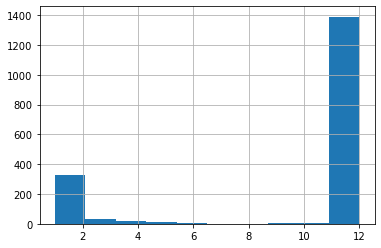

In [120]:
df_hr['Actual Duration (HH:MM:SS)'].astype('timedelta64[h]').hist()

In [121]:
df_hr['Days spend'].mean()

Timedelta('31 days 20:57:51.121718377')

In [122]:
df_hr['Days spend'].min()

Timedelta('1 days 00:00:00')

In [123]:
df_hr['Days spend'].max()

Timedelta('630 days 00:00:00')

<AxesSubplot:>

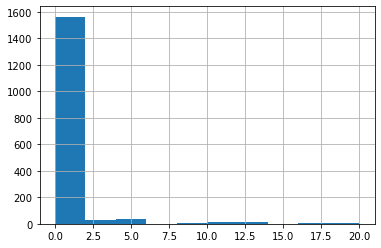

In [124]:
df_hr['Days spend'].astype('timedelta64[M]').hist()

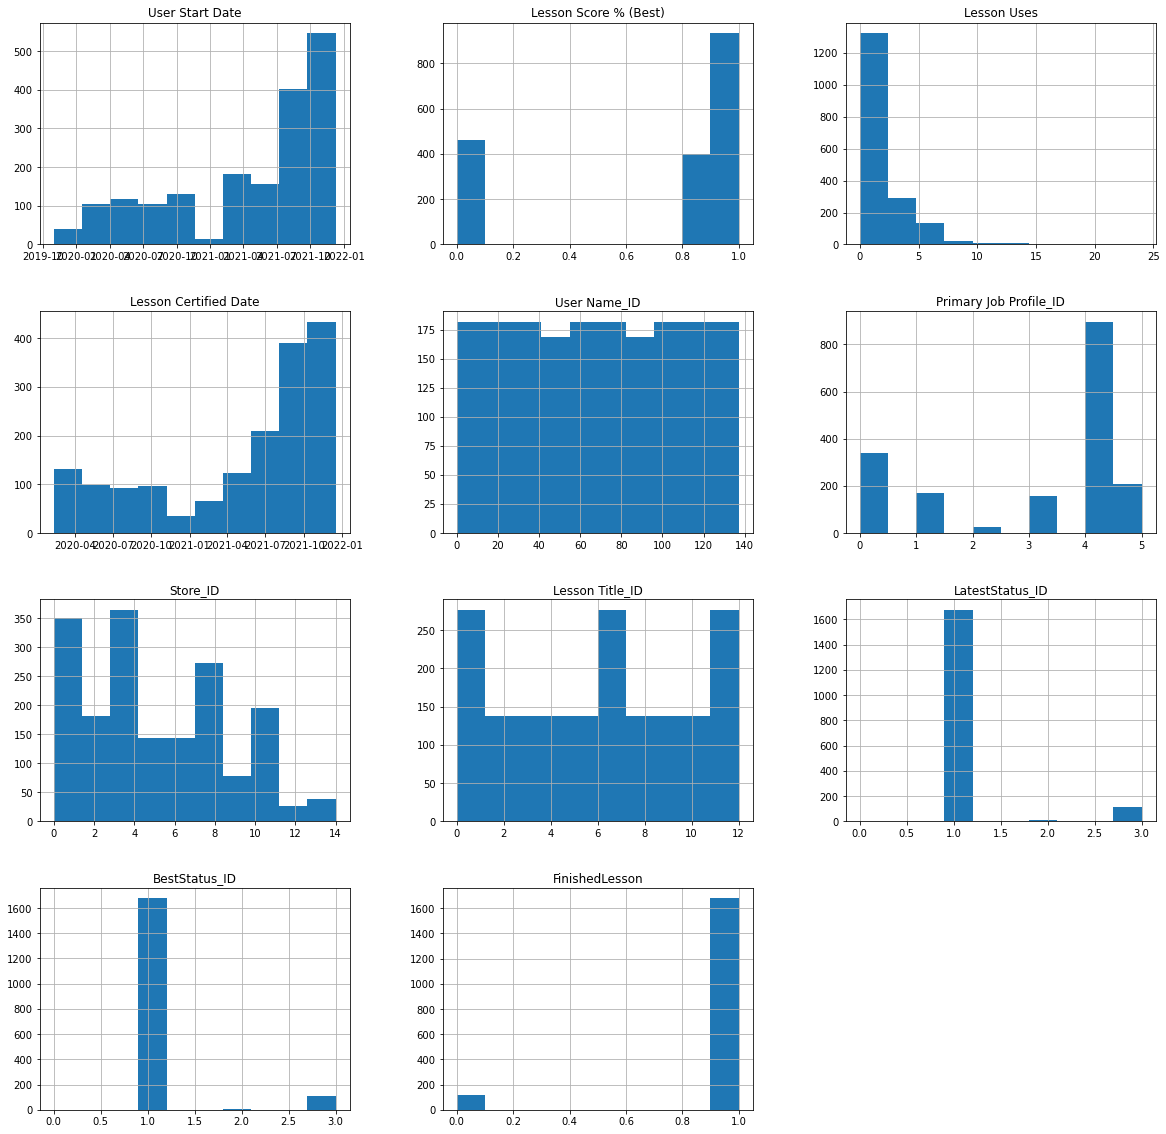

In [125]:
# Отрисуем остальные гистограммы
df_hr.hist(figsize=(20,20))
plt.show()

## Что мы видим в гистограммах

* Большинство сотрудников присоединились в последнее время. Все так, огранизация стремительно растет.
* То же относится к дате завершения курса. Если бы мы могли посмотреть корреляцию, она была бы замета
* Лучшие баллы за прохождение курса: есть часть курсов, застрявших на значении "0" - это те, что не сделаны вообще. Остальные лежат в значениях от 0,8 до 1. Тоже логично. Минимальное требование 80% правильных ответов, чтобы завершить курс
* Количество прохождений курсов: максимальное большинство проходит за 1-3 попытки, но есть и отклонения. Было бы интересно посмотреть по какому признакому есть отклонения - дело в курсе, человеке или подразделении
* Лучший и последний статус рапределены на преимущественно только два значения - большинство в "зачтено" и еще одна не очень большая, но значимая часть в "не начато", что собственно подвтерждает начальное утвержение - есть незаверешнные на сегодняшний момент курсы. Также совсем незначитальная часть курсов находится в "не завершено"
* Интересно распределение по магазинам: в каким-то из них явно больше выполненных курсов, в каких-то меньше. Отчасти это объясняется количеством сотрудников (их делением на part- и full- timer-ов). Но возможно, есть и другие причины
* Среднее время прохождения курса - около 10 часов. Это очень долго. Стоит разобраться, почему так
* Среднее время с момента начала работы в компании, за которое сотрудник проходит курсы - 31 день. Не мало. Есть пространство для улучшения

In [126]:
# Посмотрим корреляционные связи
df_hr.corr()

,Lesson Score % (Best),Lesson Uses,User Name_ID,Primary Job Profile_ID,Store_ID,Lesson Title_ID,LatestStatus_ID,BestStatus_ID,FinishedLesson
Lesson Score % (Best),1.000000,0.292967,-2.362757e-01,-8.775620e-02,-1.029480e-01,4.885063e-01,-0.437960,-0.440398,0.439069
Lesson Uses,0.292967,1.000000,-1.007809e-01,3.179571e-03,-1.074685e-01,8.382965e-02,-0.241968,-0.249478,0.245846
User Name_ID,-0.236276,-0.100781,1.000000e+00,4.677680e-01,2.728978e-01,7.110707e-17,0.395619,0.398194,-0.398971
Primary Job Profile_ID,-0.087756,0.003180,4.677680e-01,1.000000e+00,1.219960e-01,2.398167e-17,0.124145,0.127578,-0.127837
Store_ID,-0.102948,-0.107468,2.728978e-01,1.219960e-01,1.000000e+00,-8.995665e-19,0.223538,0.221312,-0.217295
Lesson Title_ID,0.488506,0.083830,7.110707e-17,2.398167e-17,-8.995665e-19,1.000000e+00,0.026473,0.025910,-0.030650
LatestStatus_ID,-0.437960,-0.241968,3.956193e-01,1.241446e-01,2.235382e-01,2.647347e-02,1.000000,0.997674,-0.990903
BestStatus_ID,-0.440398,-0.249478,3.981938e-01,1.275778e-01,2.213124e-01,2.590966e-02,0.997674,1.000000,-0.993224
FinishedLesson,0.439069,0.245846,-3.989711e-01,-1.278367e-01,-2.172955e-01,-3.064984e-02,-0.990903,-0.993224,1.000000


<AxesSubplot:>

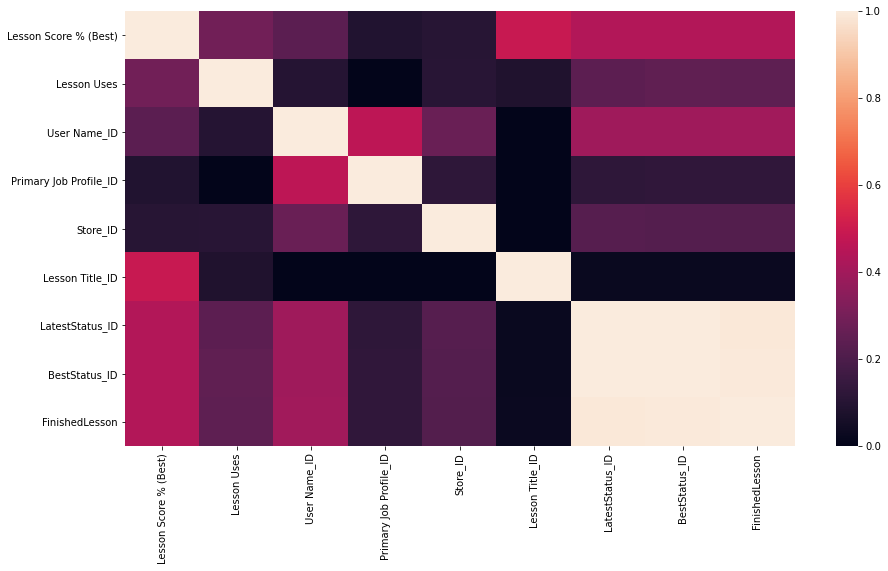

In [127]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(abs(df_hr.corr()),ax=ax)

Заметных корреляций в данных нет, кроме одной - Лучшая оценка коррелируется с послней. Что логично: сотрудник стремится достичь максимальный балл и на этом останавливает попытки пересдать курс

## Теперь посмотрим распределение сотрудников 

In [128]:
df_hr.drop_duplicates(subset=['User Name'])

,User Name,Primary Job Profile,Store,User Start Date,Lesson Code,Lesson Title,Lesson Score % (Best),Lesson Status (Latest),Lesson Status (Best),Lesson Uses,Actual Duration (HH:MM:SS),Lesson Certified Date,User Name_ID,Primary Job Profile_ID,Store_ID,Lesson Title_ID,LatestStatus_ID,BestStatus_ID,FinishedLesson,Days spend
0,168704,Sales Assistant,R007-Filion,2020-02-05,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,2,0 days 01:02:06,2020-02-13,1,4,6,1,1,1,1,8 days
13,171260,Area Responsible,R003-Moscow Kalita,2020-06-16,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 01:09:21,2020-06-21,17,0,2,1,1,1,1,5 days
26,193774,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-09-06,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 12:24:31,2021-09-16,84,4,10,1,1,1,1,10 days
39,193125,Area Responsible,R007-Filion,2021-08-24,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 12:36:51,2021-09-12,77,0,6,1,1,1,1,19 days
52,192323,Area Responsible,R008-Tula/Maksi,2021-08-05,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 01:12:57,2021-08-18,72,0,7,1,1,1,1,13 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,188945,Store Manager,R009-Moscow Kapitoliy,2021-05-25,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,2,0 days 12:40:49,2021-05-31,55,5,8,1,1,1,1,6 days
1742,170475,Deputy Store Manager,R009-Moscow Kapitoliy,2020-05-20,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,6,0 days 02:03:31,2020-05-21,12,1,8,1,1,1,1,1 days
1755,191991,Deputy Store Manager,R008-Tula/Maksi,2021-07-29,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 12:17:20,2021-08-03,69,1,7,1,1,1,1,5 days
1768,191474,Sales Assistant,R011-Krasny Kit/ Mytishi,2021-07-15,0016_RU,Внутренняя Организация,0.0,Зачтено,Зачтено,1,0 days 02:42:48,2021-07-29,62,4,10,1,1,1,1,14 days


**... Сначала по магазинам**

Text(0, 0.5, 'Employees/Users')

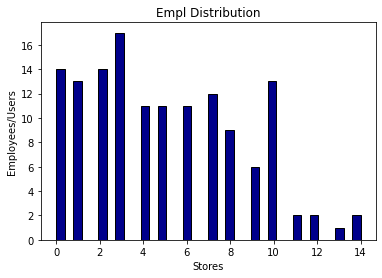

In [129]:
user_data = df_hr.drop_duplicates(subset=['User Name'])

plt.hist(user_data['Store_ID'], color = 'darkblue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Empl Distribution')
plt.xlabel('Stores')
plt.ylabel('Employees/Users')

**Потом по должностям**

Text(0, 0.5, 'Employees/Users')

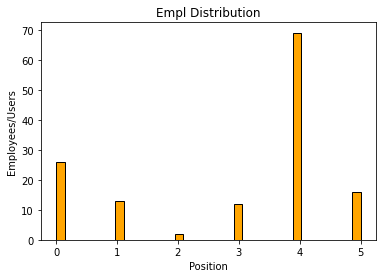

In [130]:
user_data = df_hr.drop_duplicates(subset=['User Name'])

plt.hist(user_data['Primary Job Profile_ID'], color = 'orange', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Empl Distribution')
plt.xlabel('Position')
plt.ylabel('Employees/Users')

# Моделируем


К сожалению, пока не знаю, как прогнозировать (т.е. поставить зависимой переменной) значение с типом данных timedelta (было бы интересно посомтреть, от каких переменных может зависеть скоро выполнения тренинга), по пробоуем посмотреть, от чего зависит Best Score, и как можно его прогнозировать

In [150]:
df_hr.head ()

,User Name,Primary Job Profile,Store,User Start Date,Lesson Code,Lesson Title,Lesson Score % (Best),Lesson Status (Latest),Lesson Status (Best),Lesson Uses,Actual Duration (HH:MM:SS),Lesson Certified Date,User Name_ID,Primary Job Profile_ID,Store_ID,Lesson Title_ID,LatestStatus_ID,BestStatus_ID,FinishedLesson,Days spend
0,168704,Sales Assistant,R007-Filion,2020-02-05,0016_RU,Внутренняя Организация,0.00,Зачтено,Зачтено,2,0 days 01:02:06,2020-02-13,1,4,6,1,1,1,1,8 days
1,168704,Sales Assistant,R007-Filion,2020-02-05,1001,Добро пожаловать в JYSK,0.95,Зачтено,Зачтено,5,0 days 02:24:48,2020-02-11,1,4,6,4,1,1,1,6 days
2,168704,Sales Assistant,R007-Filion,2020-02-05,1002,Продажи и Обслуживание JYSK,1.00,Зачтено,Зачтено,6,0 days 04:46:11,2020-02-11,1,4,6,10,1,1,1,6 days
3,168704,Sales Assistant,R007-Filion,2020-02-05,1003,Seamless Cross Channel - Омниканальная розничн...,0.00,Зачтено,Зачтено,2,0 days 12:16:21,2020-02-13,1,4,6,0,1,1,1,8 days
4,168704,Sales Assistant,R007-Filion,2020-02-05,2002,Одеяла,1.00,Зачтено,Зачтено,4,0 days 01:26:16,2020-02-18,1,4,6,9,1,1,1,13 days


In [151]:
X = df_hr[['Primary Job Profile_ID', 'Store_ID', 'Lesson Title_ID', 'Lesson Uses', 'BestStatus_ID']]

y = df_hr[['Lesson Score % (Best)']]

In [152]:
X

,Primary Job Profile_ID,Store_ID,Lesson Title_ID,Lesson Uses,BestStatus_ID
0,4,6,1,2,1
1,4,6,4,5,1
2,4,6,10,6,1
3,4,6,0,2,1
4,4,6,9,4,1
...,...,...,...,...,...
1789,4,10,6,1,1
1790,4,10,8,2,1
1791,4,10,12,3,1
1792,4,10,2,3,1


In [153]:
y

,Lesson Score % (Best)
0,0.00
1,0.95
2,1.00
3,0.00
4,1.00
...,...
1789,0.88
1790,1.00
1791,1.00
1792,0.88


In [154]:
from sklearn.model_selection import train_test_split

In [155]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [156]:
lin_model = LinearRegression()

lin_model.fit(X_train, Y_train)

LinearRegression()

In [157]:
importance = lin_model.coef_

print(importance)

[[-0.00472259  0.00089187  0.05279043  0.02895616 -0.35326693]]


In [158]:
def scaling(df):
    scaler = MinMaxScaler() 
    data_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(data_scaled)
    return df_scaled

In [176]:
X = df_hr[['Primary Job Profile_ID', 'Lesson Title_ID', 'Store_ID', 'Lesson Uses','BestStatus_ID']]

X_scaled = scaling(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

importance = lin_model.coef_
print(importance)

[[-0.02361295  0.63348513  0.01248623  0.69494786 -1.05980079]]


In [177]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [178]:
# Определим функцию оценки ошибки получившейся модели:

def model_access(lin_model, X_train, X_test, Y_train, Y_test):

    # model evaluation for training set
    y_train_predict = lin_model.predict(X_train)
    rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
    r2 = r2_score(Y_train, y_train_predict)

    
    print("\n")
    print("The model performance for training set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("--------------------------------------")
    print("\n")

    
    # model evaluation for testing set
    y_test_predict = lin_model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
    r2 = r2_score(Y_test, y_test_predict)

    print("The model performance for testing set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

In [179]:
model_access(lin_model, X_train, X_test, Y_train, Y_test)



The model performance for training set
--------------------------------------
RMSE is 0.29591130065295856
R2 score is 0.46714624065067156
--------------------------------------


The model performance for testing set
--------------------------------------
RMSE is 0.31154914528143973
R2 score is 0.45583451241249096


RMSE довольно высокий, но R2 приближается к 0,5, что довольно неплохо. 
Это означает, что хотя бы половину (чуть меньше) оценок мы можем объяснить этой моделью. Но с ошибками, тк RMSE высокий. В общем модель еще нужно дорабатывать

# Выводы

В датасеете мы увидели много интересного:
* 118 курсов еще не пройдены
* Среднее время прохождения уровка - 10 часов. Это очень долго, нужно углубляться в детали и узнавать причины
* Причем из гистограммы мы увидели, что значимое количество курсов пройдено за менее чем 2 часа, но все же большинство сосредоточено около 12
* Неравномерно распределено прохождение тренингов по магазинам - тут тоже нужно идти в детали
* В датасете не выявлены сильные корреляционные связи за исключением ожидаемых. Правда при этом анализе не удалось учесть временные данные
* Опробованная модель - поиск зависимости между оценкой за курс и такими показателями как магазин, должность, название курса и тд - не оказалась очень успешной для дальнейшего прогноза в будущем (RMSE - 0.311, R2 - 0,45). Наиболее значимые для модели переменные - лучший статус прохождения, название курса и количество попыток пройти курс.

Как цель для дальнейших исследований датасета можно поставить:
* формулировка моделей зависимости временных переменных от других параметров
* углубиться в детали по распределению времени на прохождение курсов в зависимости от курса, магазина, должности
* посмотреть бокс плот по опять же таймдельте (если это возможно)
* Посмотреть от чего зависит количество попыток при прохождении курса
* ну и конечно, было бы здорово совместить эти данные с другими данными по сотрудникам, например, демографическим и комменрческим и узнать, есть ли взаимосвязь между продолжительностью работы в компании, текучестью на испытательном сроке и скоростью и качеством прохождения обучения на онбординге

Итоговый вывод:
Конечно, исследование не завершено. Это скорее первое разведывательное действие, которое выявило новые направления для анализа. Удалось попробовать изученные инструменты на реальном датасете. Хочется углубиться в детали



Спасибо за курс!